## Load data

In [29]:
!pip install -U ydata-profiling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

from datetime import datetime, timedelta
import os
from tqdm import tqdm
import dask
import dask.dataframe as dd
from ydata_profiling import ProfileReport

# Beautify
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [30]:
# Load a dataset from Kaggle.com
import kagglehub

# Select file folder
path = kagglehub.dataset_download("abdelrhmanragab/ab-data")

# List all files recursively. Automatically picks the latest version
for root, dirs, files in os.walk(path):
    for file in files:
        print(f"Found file: {os.path.join(root, file)}")

file = os.path.join(file)

Found file: /kaggle/input/ab-data/countries.csv
Found file: /kaggle/input/ab-data/ab_data.csv


In [31]:
# Load to df, using file name
file_path = os.path.join(path, file)
df = pd.read_csv(file_path)

print(df.head())

df_control = df[df['group'] == 'control']
df_treatment = df[df['group'] == 'treatment']

   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1


## Data manipulation basics

In [32]:
# Determine the normalized distribution in percent of landing page unique values counts
df['landing_page'].value_counts(normalize = True)

,proportion
landing_page,
old_page,0.5
new_page,0.5


In [33]:
# Non-unique, non-null values
df['user_id'].count()

np.int64(294478)

In [34]:
# Non-unique, non-null values 2nd approach
df.shape[0]

294478

In [35]:
# DISTINCT users
df['user_id'].nunique()

290584

In [36]:
# Determine the normalized distribution of landing page unique values counts. Proportion
df['landing_page'].value_counts(normalize = True)

,proportion
landing_page,
old_page,0.5
new_page,0.5


In [37]:
# Grouped by exp_group
df.groupby('group')['landing_page'].value_counts(normalize = True) # 1 value only
# gen_habits.groupby('generation')[['monthly_orders', 'monthly_hours']].agg('mean') for 2 or more

group      landing_page
control    old_page        0.986902
           new_page        0.013098
treatment  new_page        0.986658
           old_page        0.013342
Name: proportion, dtype: float64

In [55]:
# Mean. Conversion rate for pages
df.groupby('landing_page')['converted'].agg('mean')

,converted
landing_page,
new_page,0.118841
old_page,0.120478


In [38]:
# Draw a random sample of rows
sample = 1000
sample_df = df.sample(n = sample, random_state = 42)
sample_df['landing_page'].value_counts(normalize = True)

,proportion
landing_page,
new_page,0.511
old_page,0.489


In [58]:
# A/B test data, ads agency from Kaggle.com
import kagglehub

# Select file folder
path = kagglehub.dataset_download("osuolaleemmanuel/ad-ab-testing")

# List all files recursively. Automatically picks the latest version
for root, dirs, files in os.walk(path):
    for file in files:
        print(f"Found file: {os.path.join(root, file)}")

file = os.path.join(file)

# Load to df, using file name
file_path = os.path.join(path, file)
AdSmart = pd.read_csv(file_path)

print(AdSmart.head(3))

Found file: /kaggle/input/ad-ab-testing/AdSmartABdata - AdSmartABdata.csv
                             auction_id experiment        date  hour  \
0  0008ef63-77a7-448b-bd1e-075f42c55e39    exposed  2020-07-10     8   
1  000eabc5-17ce-4137-8efe-44734d914446    exposed  2020-07-07    10   
2  0016d14a-ae18-4a02-a204-6ba53b52f2ed    exposed  2020-07-05     2   

          device_make  platform_os                browser  yes  no  
0  Generic Smartphone            6          Chrome Mobile    0   0  
1  Generic Smartphone            6          Chrome Mobile    0   0  
2               E5823            6  Chrome Mobile WebView    0   1  


In [65]:
# Filter on users who responded

# | = or
# & = and

AdSmart_Responded = AdSmart[(AdSmart['yes'] == 1) | (AdSmart['no'] == 1)]
AdSmart_Responded.sample()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
4512,8fd47d20-07e3-43d2-99b2-f511221037a2,exposed,2020-07-06,5,Generic Smartphone,6,Chrome Mobile,0,1


In [71]:
# Find the counts of yes after 2020-07-05 per experiment
# AdSmart_Responded.groupby('experiment')['date'].value_counts()
AdSmart_Responded[(AdSmart_Responded['yes']) & (AdSmart_Responded['date'] > '2020-07-05')].value_counts()

,yes
experiment,
control,242
exposed,400


In [78]:
# Group by + date filter
AdSmart_Responded_Group = AdSmart_Responded.groupby(['experiment', 'date'])['yes'].count().reset_index()
AdSmart_Responded_after_date = AdSmart_Responded_Group[AdSmart_Responded_Group['date'] > '2020-07-05']

AdSmart_Responded_after_date.head(3)

,experiment,date,yes
3,control,2020-07-06,26
4,control,2020-07-07,37
5,control,2020-07-08,58


In [79]:
# Group by + filter in 1 action
AdSmart_Responded[(AdSmart_Responded['date'] > '2020-07-05')].groupby('experiment').count()

,auction_id,date,hour,device_make,platform_os,browser,yes,no
experiment,,,,,,,,
control,242,242,242,242,242,242,242,242
exposed,400,400,400,400,400,400,400,400


In [81]:
# Proportion of users who responded 'yes' by experiment type
AdSmart_Responded.groupby('experiment')['yes'].mean()

,yes
experiment,
control,0.450512
exposed,0.468798


In [84]:
# Proportion, alternative
AdSmart_Responded.groupby('experiment')['yes'].value_counts(normalize = True)

experiment  yes
control     0      0.549488
            1      0.450512
exposed     0      0.531202
            1      0.468798
Name: proportion, dtype: float64

In [85]:
# Proportion of users who responded 'yes' by experiment type and platform OS
AdSmart_Responded.groupby(['experiment','platform_os'])['yes'].mean()

experiment  platform_os
control     5              0.307692
            6              0.453752
exposed     5              0.250000
            6              0.470138
Name: yes, dtype: float64

## A/B basics

In [39]:
from scipy import stats
stats.shapiro(df['converted'])
# Statistic (W) = 1
# p-vanue = 0.05

ShapiroResult(statistic=np.float64(0.3783523831943343), pvalue=np.float64(7.449811514912522e-196))

In [40]:
# Do the same for control and treatment
stats.shapiro(df_control['converted'])

ShapiroResult(statistic=np.float64(0.3796275611064569), pvalue=np.float64(1.8454516993263413e-178))

In [41]:
stats.shapiro(df_treatment['converted'])

ShapiroResult(statistic=np.float64(0.3770708618973132), pvalue=np.float64(1.2868242482784328e-178))

Conclusion - values diviate extremely, meaning it's NOT normally distributed

In [42]:
df_treatment[df_treatment['converted'] == 1].user_id.count()/df_treatment.shape[0]
# 11% conversions, treatment

np.float64(0.11891957956489856)

In [43]:
df_control[df_control['converted'] == 1].user_id.count()/df_control.shape[0]
# 11% conversions, treatment

np.float64(0.12039917935897611)

In [44]:
# Load a fraud retection dataset from Kaggle.com
import kagglehub
import os

# Select file folder
path = kagglehub.dataset_download("aryan208/financial-transactions-dataset-for-fraud-detection")

# List all files recursively. Automatically picks the latest version
for root, dirs, files in os.walk(path):
    for file in files:
        print(f"Found file: {os.path.join(root, file)}")

file = os.path.join(file)

Found file: /kaggle/input/financial-transactions-dataset-for-fraud-detection/financial_fraud_detection_dataset.csv


In [45]:
# Load to df, using file name
file_path = os.path.join(path, file)
df_fin_fraud_detection = pd.read_csv(file_path)

In [46]:
df_fin_fraud_detection.sample(1)

,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
1479652,T1579652,2023-02-25T06:42:02.792321,ACC819190,ACC371210,1592.37,deposit,travel,London,mobile,False,NaN,NaN,-1.03,19,0.44,wire_transfer,97.135.8.146,D5197322


## Sampling 1o1

In [47]:
# Simple, straightforward method. Not clean samples
df_fin_fraud_detection_sample_simple = df_fin_fraud_detection.sample(10000)

In [48]:
# Stratified Sampling:
from sklearn.model_selection import train_test_split

df_sampled, _ = train_test_split(
    df_fin_fraud_detection,
    train_size=10000,
    stratify=df_fin_fraud_detection['is_fraud'],
    random_state=42
)

In [49]:
# which one is the best?

## Pearson's probability

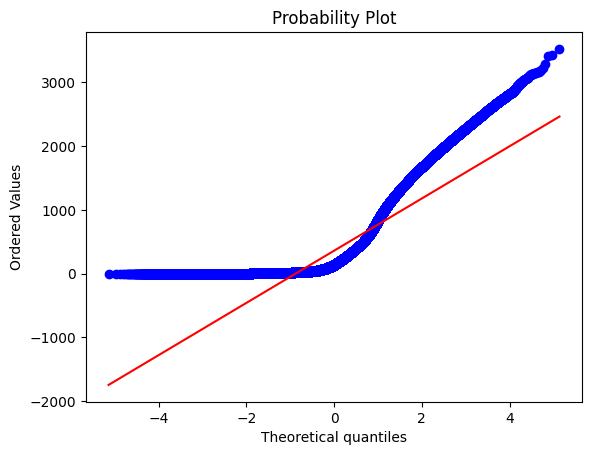

In [50]:
# Probability plot is NOT useful in that sort of data!
# Make a new dataset for this example!
measurements = np.random.normal(loc=20, scale=5, size=100)
stats.probplot(df_fin_fraud_detection['amount'], dist="norm", plot=pylab)
plt.show()

## Pearson's correlation, r = 1 / 0 / -1. Vizualization + calculation

In [51]:
# pandas.corr()
df_fin_fraud_detection_sample_simple[['spending_deviation_score', 'velocity_score', 'geo_anomaly_score']].corr(method='pearson')

,spending_deviation_score,velocity_score,geo_anomaly_score
spending_deviation_score,1.000000,0.013203,-0.000656
velocity_score,0.013203,1.000000,-0.023420
geo_anomaly_score,-0.000656,-0.023420,1.000000


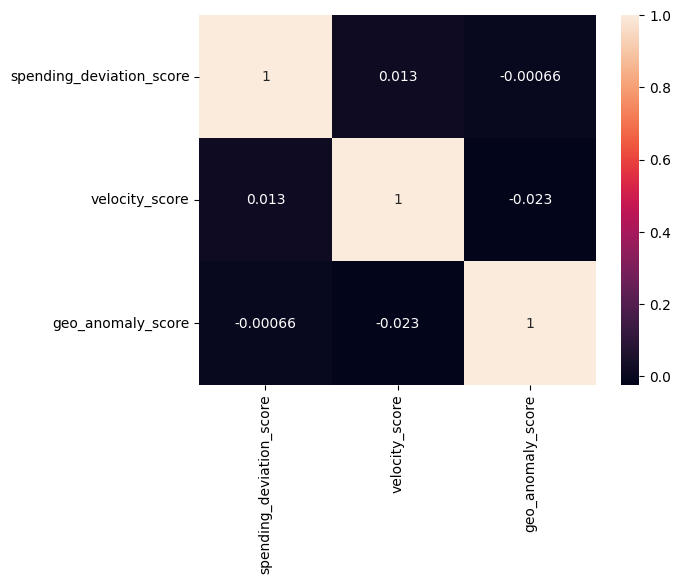

In [52]:
# heatmap
sns.heatmap(df_fin_fraud_detection_sample_simple[['spending_deviation_score', 'velocity_score', 'geo_anomaly_score']].corr(method='pearson'), annot = True)
plt.show()

## causal relationship